# Explore Data Analysis Notebook
We will try in this notebook to find risk factors for CKD from provided features

## Imports

In [14]:
# Global Tools
import json
import os

# Math / Data Manipulation
import numpy as np
from scipy.io import arff
import pandas as pd
import math

# Viz
from matplotlib import pyplot as plt
import plotly.express as px


## Load Config

In [15]:
with open('../config.json', 'r') as f:
  config = json.load(f)
  
ROOT = os.path.dirname(os.path.abspath(os.path.curdir))

## Load Dataset

In [16]:
path_to_dataset_file = os.path.join(ROOT, config['dataset_dir'], config['dataset_file'])

data = arff.loadarff(path_to_dataset_file) # Work with advices found here : https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io
df = pd.DataFrame(data[0])

print(f"Dataset Shape : {df.shape}")
df.head()


Dataset Shape : (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,b'1.020',b'1',b'0',b'?',b'normal',b'notpresent',b'notpresent',121.0,...,44.0,7800.0,5.2,b'yes',b'yes',b'no',b'good',b'no',b'no',b'ckd'
1,7.0,50.0,b'1.020',b'4',b'0',b'?',b'normal',b'notpresent',b'notpresent',NaN,...,38.0,6000.0,NaN,b'no',b'no',b'no',b'good',b'no',b'no',b'ckd'
2,62.0,80.0,b'1.010',b'2',b'3',b'normal',b'normal',b'notpresent',b'notpresent',423.0,...,31.0,7500.0,NaN,b'no',b'yes',b'no',b'poor',b'no',b'yes',b'ckd'
3,48.0,70.0,b'1.005',b'4',b'0',b'normal',b'abnormal',b'present',b'notpresent',117.0,...,32.0,6700.0,3.9,b'yes',b'no',b'no',b'poor',b'yes',b'yes',b'ckd'
4,51.0,80.0,b'1.010',b'2',b'0',b'normal',b'normal',b'notpresent',b'notpresent',106.0,...,35.0,7300.0,4.6,b'no',b'no',b'no',b'good',b'no',b'no',b'ckd'


## Some Preprocess

In [17]:
# Rename column names to make it more understandable
path_to_info_file = os.path.join(ROOT, config['dataset_dir'], config['dataset_info_file'])
with open(path_to_info_file) as info_file:
    columns_and_desc = info_file.readlines()[31:56]
columns_names = map(lambda s : s.split('-')[1].strip().replace(' ', '_'), columns_and_desc)

df.columns = columns_names

# Decode byte to utf8
str_df = df.select_dtypes([object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]
    
df.head()


,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1,0,?,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4,0,?,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2,3,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2,0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


## Global Analysis

In [18]:
df.describe()

,age,blood_pressure,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count
count,391.000000,388.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      391 non-null    float64
 1   blood_pressure           388 non-null    float64
 2   specific_gravity         400 non-null    object 
 3   albumin                  400 non-null    object 
 4   sugar                    400 non-null    object 
 5   red_blood_cells          400 non-null    object 
 6   pus_cell                 400 non-null    object 
 7   pus_cell_clumps          400 non-null    object 
 8   bacteria                 400 non-null    object 
 9   blood_glucose_random     356 non-null    float64
 10  blood_urea               381 non-null    float64
 11  serum_creatinine         383 non-null    float64
 12  sodium                   313 non-null    float64
 13  potassium                312 non-null    float64
 14  hemoglobin               3

## Features Analysis

In [20]:
target_col = config.get("target_col")
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype != 'object']
print(f"Number of categorical cols : {len(categorical_cols)}, Number of numerical cols : {len(numerical_cols)}")

Number of categorical cols : 14, Number of numerical cols : 11


### Numerical Features Analysis

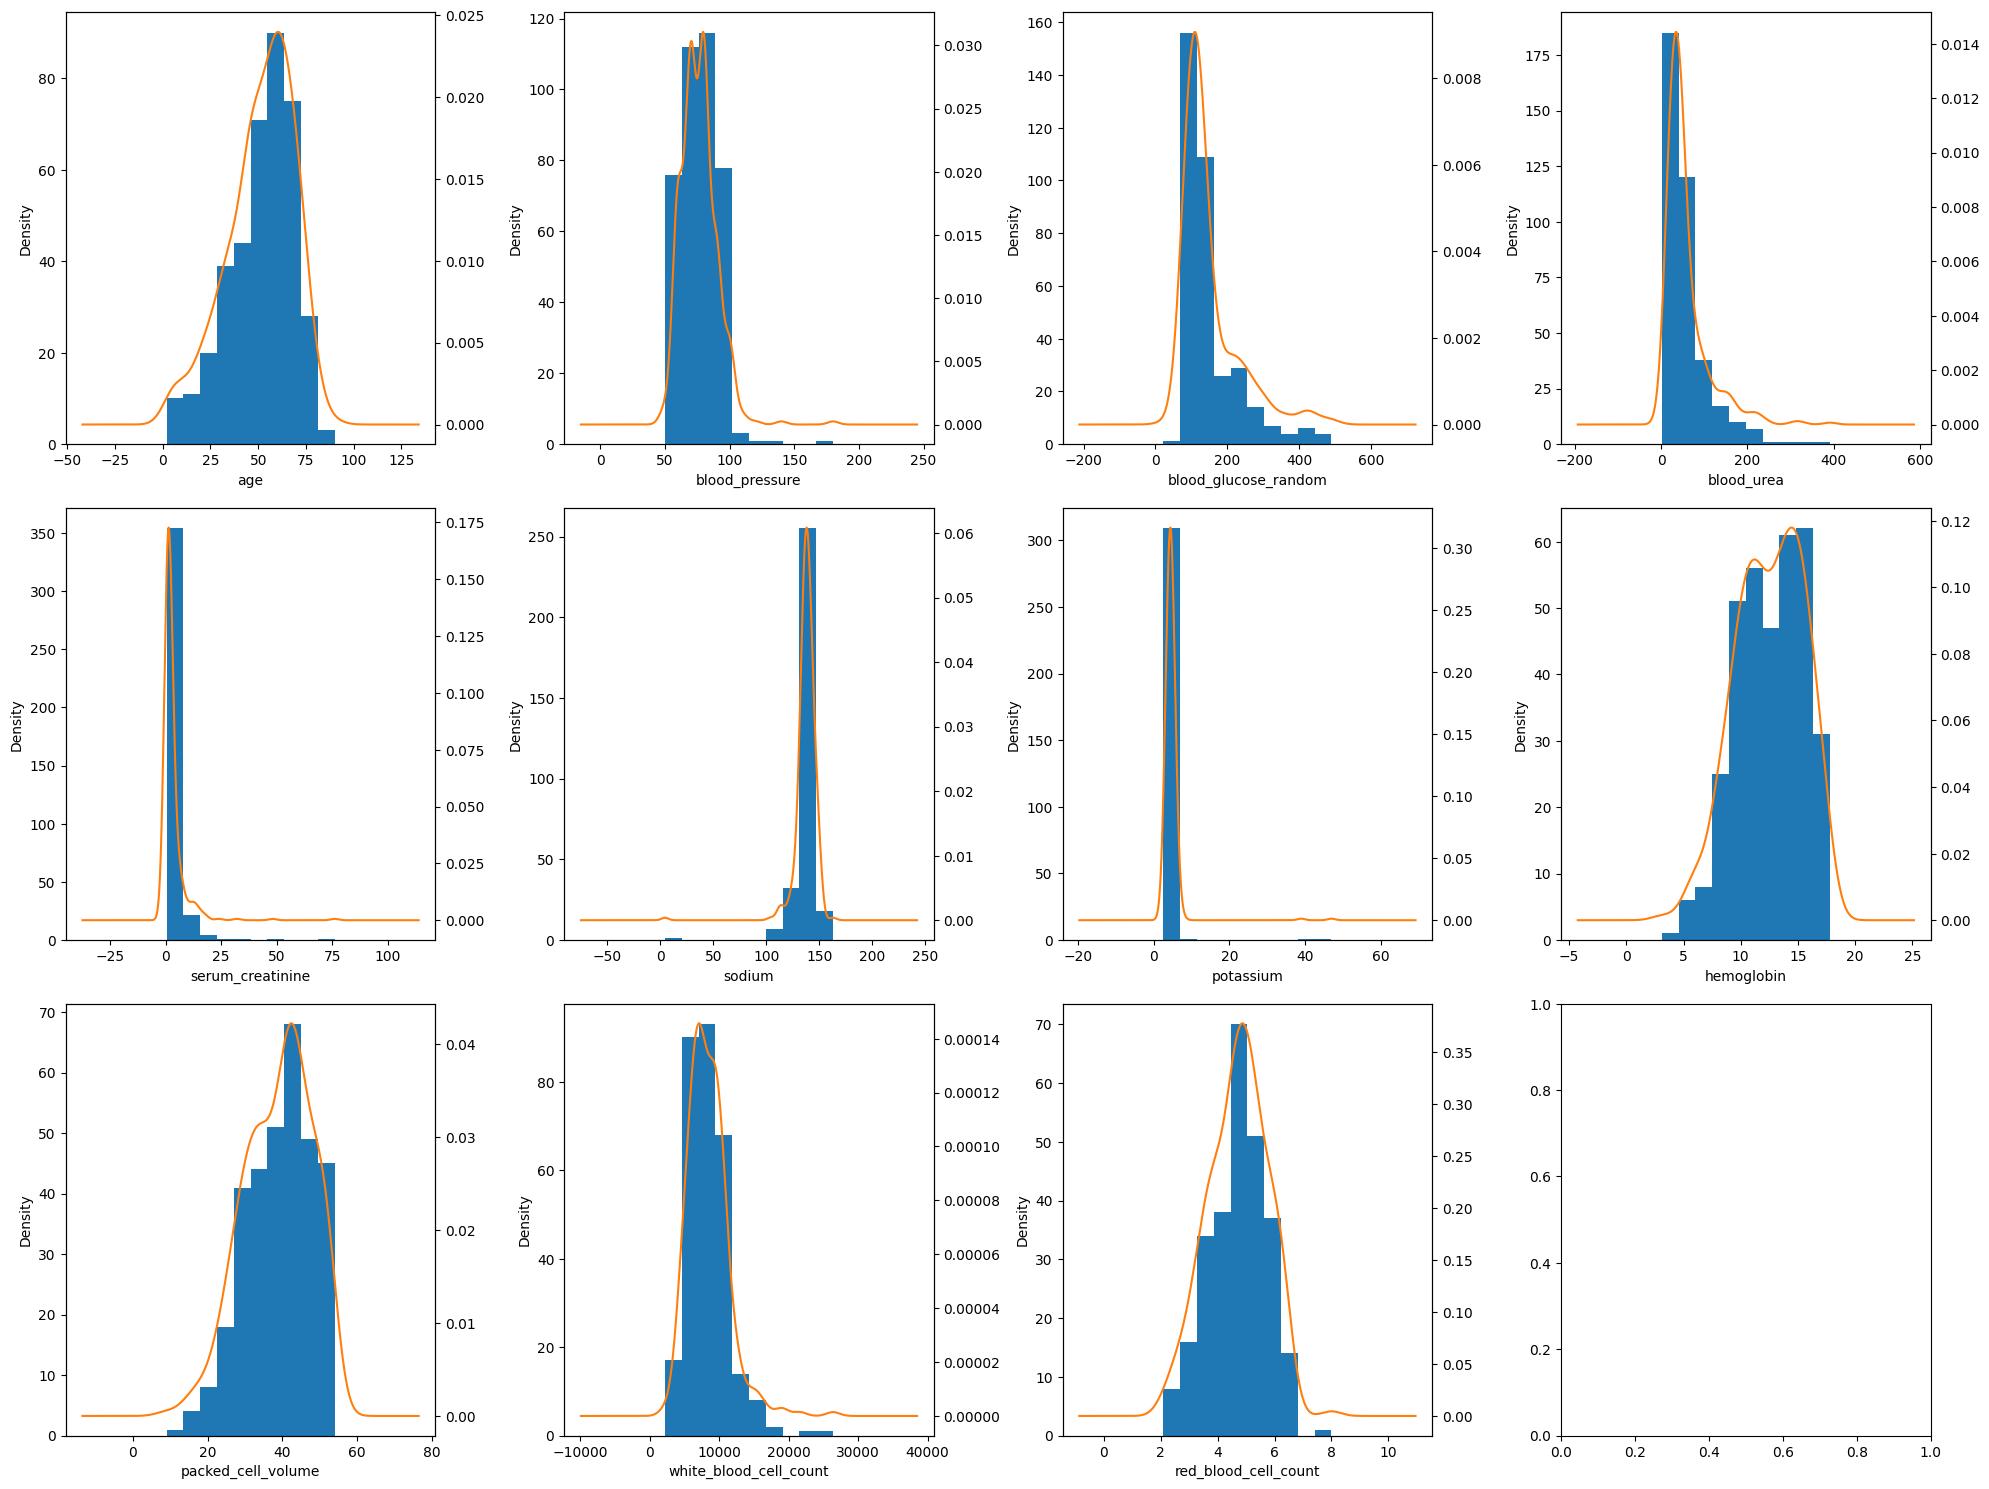

In [21]:
ncol = 4
nrow = math.ceil(len(numerical_cols) / ncol)

fig, axs = plt.subplots(nrow, ncol, figsize=(20, 15))
axs = axs.flatten()

for column, ax in zip(numerical_cols, axs):
    ax.set_xlabel(column)
    df[column].plot.hist(ax=ax)
    df[column].plot.kde(ax=ax, secondary_y=True)

fig.tight_layout()


In [22]:
for column in numerical_cols:
    fig = px.violin(df, y=column, x=target_col, color=target_col, box=True)
    fig.show()

# These are plotly graphs (invisible on Github preview)

### Categorical features Analysis

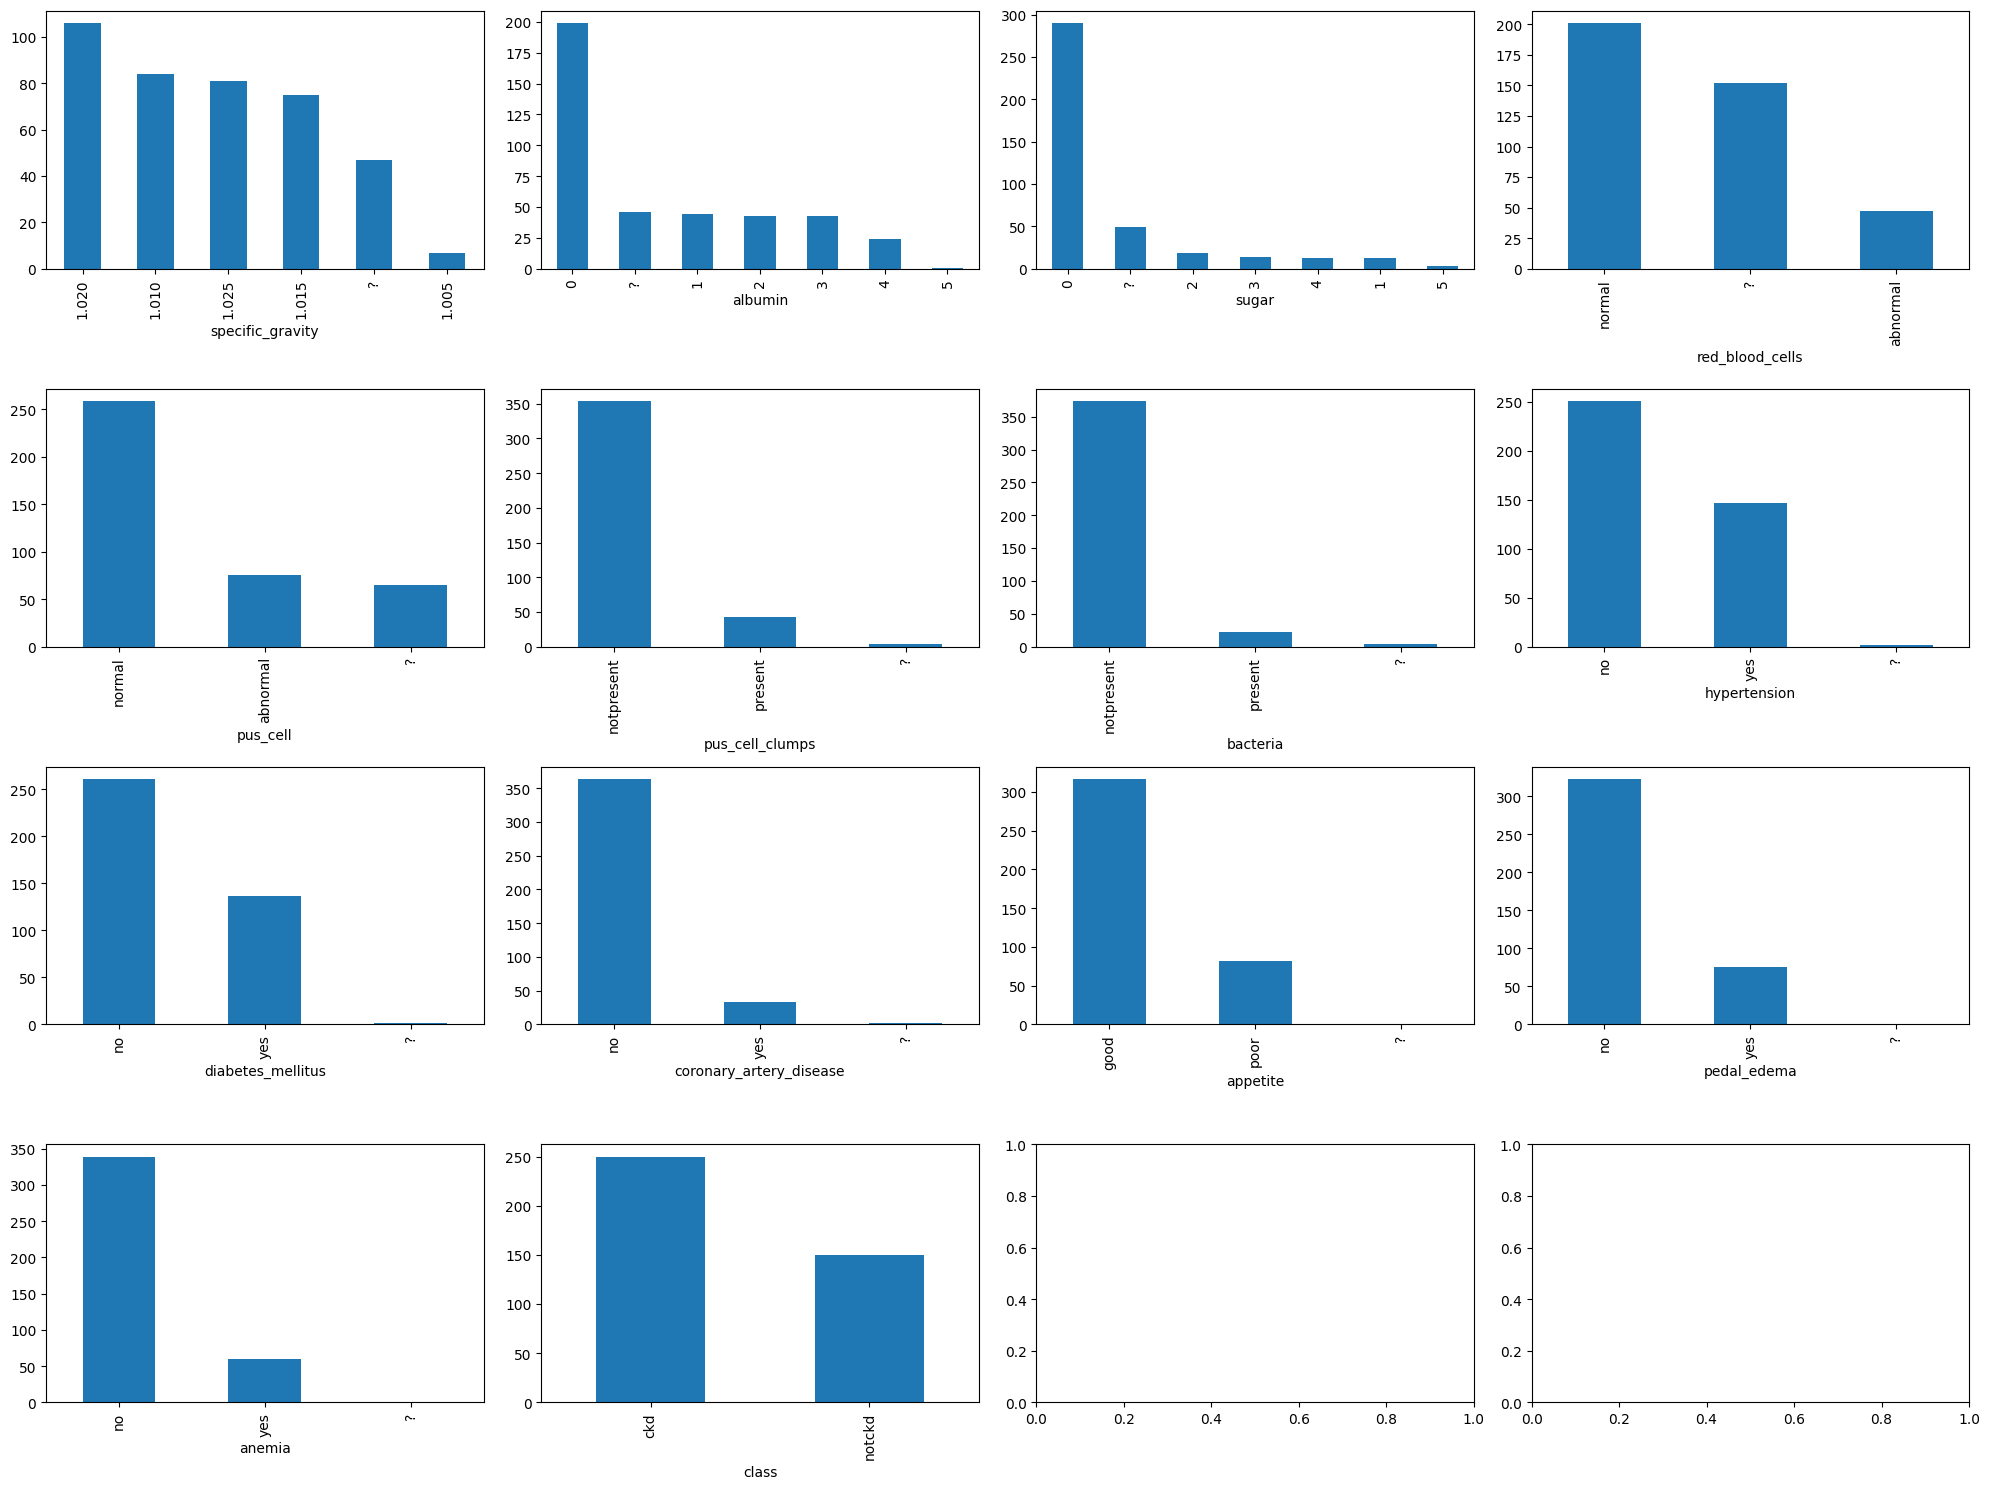

In [23]:

ncol = 4
nrow = math.ceil(len(categorical_cols) / ncol)

fig, axs = plt.subplots(nrow, ncol, figsize=(20, 15))
axs = axs.flatten()

for column, ax in zip(categorical_cols, axs):
    ax.set_xlabel(column)
    df[column].value_counts().plot(kind='bar', ax=ax)

fig.tight_layout()

In [24]:
for column in categorical_cols:
    fig = px.bar(df, x=column, color=target_col, barmode="group")
    fig.show()

# These are plotly graphs (invisible on Github preview)